<a href="https://colab.research.google.com/github/laggyperson/URAP-Sumo-Data-Collection/blob/main/Data_Setup_for_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About
This is me learning how to import/format data for training with TensorFlow

Link to followed tutorial:
Beginner (Titanic): https://www.tensorflow.org/tutorials/load_data/csv#basic_preprocessing

Pandas-like Data: https://www.tensorflow.org/tutorials/load_data/pandas_dataframe

General Data Pipeline + Batching: https://www.tensorflow.org/guide/data

In [1]:
import xarray as xr
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pathlib # For mapping data examples
import os

# Notes
The goal of setting up the data is to create a training and a test data set. Then you have to normalize and batch it before sending it to the model. Depending on what data you have + the model, you need to process it differently.

If your data consists of all the same data type (say a numpy array of ints), then all you need to do is to split it into training and test sets, batch it, and then feed it into the model.

Before feeding data that has differnt data types into the model, you need to preprocess it. This step can help convert the data into consistent datatypes as well as other things (I don't konw yet).

Keras has a nice way of creating layered preprocessing models where you can set up what data you will feed into the model and tell it what to do with it. You save this preprocessing model with the model itself, so if you ever retrain it, you have it set up already.

Afterwards is to batch the data. Batching the data is grouping the data into chunks that will be fed into the neural network every epoch.

# Preprocessing Model/Head
For string data values, it is recommended to use one-hot encoding or some similar sort of encoding to reduce bias.

Sometimes, just using a map function is enough.

General Steps:
1. For each column/category, create an input layer specifying the datatype and the shape of the category (usually just 1-dimensional/depth).
2. Concatenate the input layers as a blueprint/database
3. Group the data types together
4. Special Processes
    * Add normalization function for integer layers
    * If you have categorical variables, use StringLookup and CategoricalEncoding to encode these non-integer variables
    * Binary variables can be left as is
6. Concatenate every layer
7. Create a model with the concatenated inputs from step 2. and the preprocessing layers from step 6.
8. The result is a preprocessing head. Can display with tf.keras.utils.plot_model()

In [14]:
# Loading Data
xds = xr.open_dataset("drive/MyDrive/Colab Notebooks/G16_100v_noLC.nc")
xarr = xds["Data"]

feature_labels = [label for label in xarr["Data Labels"].data if label != "Passed Point"]
xarr_features = xarr.sel({"Data Labels":feature_labels})
xarr_label = xarr.sel({"Data Labels":"Passed Point"}).data[0]

In [15]:
# Creating input layers
inputs = {}

for label in xarr_features["Data Labels"].data:
  dtype = tf.float32
  if label == "Traffic Light State":
    dtype = tf.string

  inputs[label] = tf.keras.Input(shape=(1,), name=label, dtype=dtype)

# inputs

In [16]:
# Putting together numeric input layers
numeric_inputs = {label:input for label, input in inputs.items() if input.dtype==tf.float32}

# Concatenating the layers
temp = layers.Concatenate()(list(numeric_inputs.values()))

# Setting up the norm layer
norm = layers.Normalization()
# Adapt gets the standard deviation and mean of inputted data
norm.adapt(xarr_features.sel({"Data Labels":list(numeric_inputs.keys())}).data[0].astype(float))

# Feeding the concatenated layers through a norm layer
all_numeric_inputs = norm(temp)

all_numeric_inputs

<KerasTensor: shape=(None, 15) dtype=float32 (created by layer 'normalization')>

In [17]:
preprocessed_inputs = [all_numeric_inputs]

In [18]:
# Categorical variable
res = []
for label in xarr_features["Data Labels"].data:
  if label != "Traffic Light State":
    continue
  lookup = layers.StringLookup(vocabulary=np.unique(xarr_features.sel({"Data Labels":label}).data))
  one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

  x = lookup(inputs["Traffic Light State"])
  x = one_hot(x)
  res.append(x)

In [19]:
# Final result
preprocessed_inputs = [all_numeric_inputs] + res
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

sim1_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

# tf.keras.utils.plot_model(model=sim1_preprocessing, rankdir="LR", dpi=108, show_shapes=True)

In [20]:
def create_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    layers.Dense(64),
    layers.Dense(1)
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam())
  return model

xarr_features_dict = {}
for label in xarr_features["Data Labels"].data:
  typ = float
  if label == "Traffic Light State":
    xarr_features_dict[label] = xarr.sel({"Data Labels":label}).data[0]
    continue
  xarr_features_dict[label] = xarr.sel({"Data Labels":label}).data[0].astype(typ)

features_dict = {name:values[:1] for name, values in xarr_features_dict.items()}
sim1_preprocessing(features_dict)

sim1_model = create_model(sim1_preprocessing, inputs)

In [21]:
f = sim1_preprocessing(xarr_features_dict)
labels = pd.Series(xarr_label.astype(float))
sim1_model.fit(x=xarr_features_dict, y=labels, epochs=20)

Epoch 1/20
4/4 [==============================] - 1s 6ms/step - loss: 0.7683
Epoch 2/20
4/4 [==============================] - 0s 4ms/step - loss: 0.6755
Epoch 3/20
4/4 [==============================] - 0s 4ms/step - loss: 0.6082
Epoch 4/20
4/4 [==============================] - 0s 4ms/step - loss: 0.5560
Epoch 5/20
4/4 [==============================] - 0s 4ms/step - loss: 0.5150
Epoch 6/20
4/4 [==============================] - 0s 4ms/step - loss: 0.4806
Epoch 7/20
4/4 [==============================] - 0s 4ms/step - loss: 0.4470
Epoch 8/20
4/4 [==============================] - 0s 4ms/step - loss: 0.4120
Epoch 9/20
4/4 [==============================] - 0s 4ms/step - loss: 0.3806
Epoch 10/20
4/4 [==============================] - 0s 4ms/step - loss: 0.3528
Epoch 11/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3284
Epoch 12/20
4/4 [==============================] - 0s 4ms/step - loss: 0.3060
Epoch 13/20
4/4 [==============================] - 0s 4ms/step - loss: 0.

### Titanic Example

In [21]:
titanic = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_features = titanic.copy()
titanic_labels = titanic_features.pop('survived')
titanic_features_dict = {name: np.array(value)
                         for name, value in titanic_features.items()}

print(type(titanic_labels))

<class 'pandas.core.series.Series'>


In [105]:
inputs = {}

for name, column in titanic_features.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = layers.Normalization()
norm.adapt(np.array(titanic[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

preprocessed_inputs = [all_numeric_inputs]

for name, input in inputs.items():
  if input.dtype == tf.float32:
    continue

  lookup = layers.StringLookup(vocabulary=np.unique(titanic_features[name]))
  one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

titanic_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

titanic_features_dict = {name: np.array(value)
                         for name, value in titanic_features.items()}

def titanic_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    layers.Dense(64),
    layers.Dense(1)
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam())
  return model

titanic_model = titanic_model(titanic_preprocessing, inputs)

for label, arr in titanic_features_dict.items():
  print(type(arr[0]))

print(type(titanic_labels))
# print(titanic_model.summary())
# titanic_model.fit(x=titanic_features_dict, y=titanic_labels, epochs=10)

<class 'str'>
<class 'numpy.float64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.float64'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'pandas.core.series.Series'>


### Binary Inputs

There are special layers/ways to handle binary inputs (yes or no, 1 or 0, etc.)

These don't need to be encoded or normalized like other types of variables.

In [26]:
# # I'm not putting in passed point, so this code won't work
# binary_inp = inputs["Passed Point"]

# # Add vector axis
# inp = inp[:, tf.newaxis]
# float_layer = tf.cast(inp, tf.float32)
# preprocessed_inputs = all_numeric_inputs + res + [float_layer]

## Mapping
Just instances of how to use mapping function

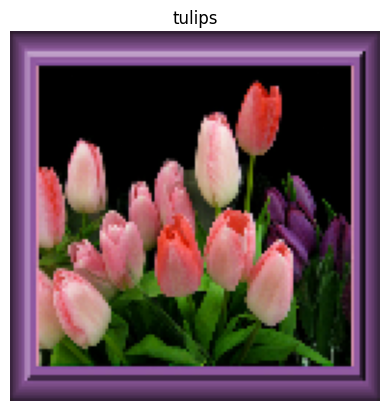

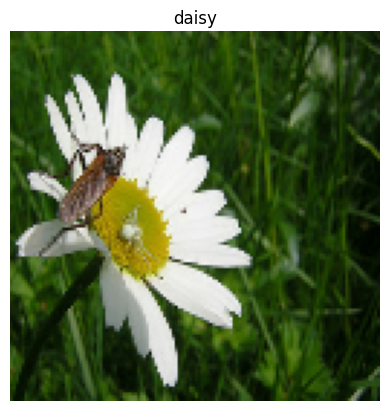

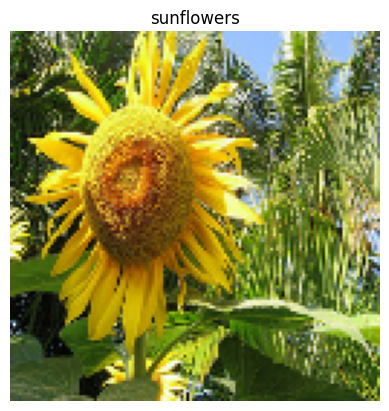

In [47]:
flowers_root = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)
flowers_root = pathlib.Path(flowers_root)
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def parse_image(filename):
  parts = tf.strings.split(filename, os.sep)
  label = parts[-2]

  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [128, 128])
  return image, label

file_path = next(iter(list_ds))
image, label = parse_image(file_path)

def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label.numpy().decode('utf-8'))
  plt.axis('off')

show(image, label)

images_ds = list_ds.map(parse_image)

for image, label in images_ds.take(2):
  show(image, label)

## Parsing `tf.Example` protocol buffer messages

Just converting features into tensors

In [48]:
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec", "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")
dataset = tf.data.TFRecordDataset(filenames = [fsns_test_file])
dataset

7904079/7904079 [==============================] - 0s 0us/step


<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

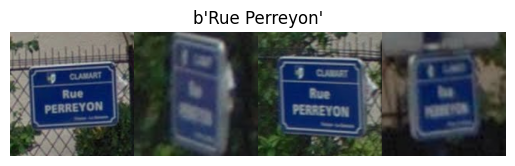

In [52]:
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())

feature = parsed.features.feature
raw_img = feature['image/encoded'].bytes_list.value[0] # Extrcting raw image)
img = tf.image.decode_png(raw_img)
plt.imshow(img)
plt.axis('off')
_ = plt.title(feature["image/text"].bytes_list.value[0]) # Getting the name of the image

In [53]:
raw_example = next(iter(dataset))

In [54]:
def tf_parse(eg):
  example = tf.io.parse_example(
      eg[tf.newaxis], {
          'image/encoded': tf.io.FixedLenFeature(shape=(), dtype=tf.string), # This function is a configuration on parsing fixed-length input features
          'image/text': tf.io.FixedLenFeature(shape=(), dtype=tf.string)
      }
  )
  return example['image/encoded'][0], example['image/text'][0]

In [55]:
img, txt = tf_parse(raw_example)
print(txt.numpy())
print(repr(img.numpy()[:20]), "...")

b'Rue Perreyon'
b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02X' ...


In [56]:
decoded = dataset.map(tf_parse) # Applying this function to the whole dataset
decoded

<_MapDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [57]:
image_batch, text_batch = next(iter(decoded.batch(10)))
image_batch.shape

TensorShape([10])

## Time Series: What I am doing

In [58]:
# Example data
range_ds = tf.data.Dataset.range(100000)

In [59]:
# Most likely want to batch data to represent the contiguous time sample
batches = range_ds.batch(10, drop_remainder=True)
for batch in batches.take(5):
  print(batch.numpy())

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]
[40 41 42 43 44 45 46 47 48 49]


In [61]:
# For prediction one step in to the future, may shift the features by one step

def dense_1_step(batch):
  # Labels and features 1 step off from each other
  return batch[:-1], batch[1:]

predict_dense_1_step = batches.map(dense_1_step)

for features, label in predict_dense_1_step.take(3):
  print("Features: ", features.numpy(), "=>", "Labels: ", label.numpy())

Features:  [0 1 2 3 4 5 6 7 8] => Labels:  [1 2 3 4 5 6 7 8 9]
Features:  [10 11 12 13 14 15 16 17 18] => Labels:  [11 12 13 14 15 16 17 18 19]
Features:  [20 21 22 23 24 25 26 27 28] => Labels:  [21 22 23 24 25 26 27 28 29]


In [62]:
# For predicting a window, split batches into two parts
batches = range_ds.batch(15, drop_remainder=True)

def label_next_5_steps(batch):
  return (batch[:-5], batch[-5:]) # Predict last 5 steps

predict_5_steps = batches.map(label_next_5_steps)

for features, label in predict_5_steps.take(3):
  print(features.numpy(), "=>", label.numpy())

[0 1 2 3 4 5 6 7 8 9] => [10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24] => [25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39] => [40 41 42 43 44]


In [64]:
# If you want some overlapping between batches, zip the data
feature_length = 10
label_length = 3

features = range_ds.batch(feature_length, drop_remainder=True)
# Here you skip 1 element and then keep only the first label_length elements that will correspond to the first elements of the next batch
labels = range_ds.batch(feature_length).skip(1).map(lambda labels: labels[:label_length])
predicted_steps = tf.data.Dataset.zip((features, labels))

for features, label in predicted_steps.take(5):
  print(features.numpy(), "=>", label.numpy())

[0 1 2 3 4 5 6 7 8 9] => [10 11 12]
[10 11 12 13 14 15 16 17 18 19] => [20 21 22]
[20 21 22 23 24 25 26 27 28 29] => [30 31 32]
[30 31 32 33 34 35 36 37 38 39] => [40 41 42]
[40 41 42 43 44 45 46 47 48 49] => [50 51 52]


In [67]:
# Can also use a windows for finer control
# Warning is that you need some more care in how to use
# Returns a Dataset of Datasets (like nested Datasets)
window_size = 5

# Shift specifies how much to shift the window each time
# There is also a stride parameter that specifies how far apart each element in each window are
# Can also drop elements if they don't divide into the window_size
windows = range_ds.window(window_size, shift=1)
for sub_ds in windows.take(5):
  print(sub_ds)

<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>


In [70]:
# Can subsequently combine all these datasets
# Here, windows.flat_map will be a Dataset, and we can take 30 items from it
for x in windows.flat_map(lambda x: x).take(30):
  print(x.numpy(), end=" ") # This end is just a print parameter, nothing special

0 1 2 3 4 1 2 3 4 5 2 3 4 5 6 3 4 5 6 7 4 5 6 7 8 5 6 7 8 9 

In [71]:
# Will want to batch before flattening
def sub_to_batch(sub):
  return sub.batch(window_size, drop_remainder=True)

# Here the entire dataset is flattened and then batched in the process, so the returned item is a batched dataset
for example in windows.flat_map(sub_to_batch).take(5):
  print(example.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]


One can combine everything above into a handy function

In [72]:
def make_window_dataset(ds, window_size=5, shift=1, stride=1):
  windows = ds.window(window_size, shift=shift, stride=stride)

  def sub_to_batch(sub):
    return sub.batch(window_size, drop_remainder=True)

  windows = windows.flat_map(sub_to_batch)
  return windows

In [73]:
ds = make_window_dataset(range_ds, window_size=10, shift = 5, stride=3)

for example in ds.take(10):
  print(example.numpy())

[ 0  3  6  9 12 15 18 21 24 27]
[ 5  8 11 14 17 20 23 26 29 32]
[10 13 16 19 22 25 28 31 34 37]
[15 18 21 24 27 30 33 36 39 42]
[20 23 26 29 32 35 38 41 44 47]
[25 28 31 34 37 40 43 46 49 52]
[30 33 36 39 42 45 48 51 54 57]
[35 38 41 44 47 50 53 56 59 62]
[40 43 46 49 52 55 58 61 64 67]
[45 48 51 54 57 60 63 66 69 72]


In [74]:
# Extracting labels
dense_labels_ds = ds.map(dense_1_step) # remember, this associates the current window with the next

for inputs, labels in dense_labels_ds.take(3):
  print(inputs.numpy(), "=>", labels.numpy())

[ 0  3  6  9 12 15 18 21 24] => [ 3  6  9 12 15 18 21 24 27]
[ 5  8 11 14 17 20 23 26 29] => [ 8 11 14 17 20 23 26 29 32]
[10 13 16 19 22 25 28 31 34] => [13 16 19 22 25 28 31 34 37]


## Resampling
Often needed for data with class-imabalances (skewed data, data with groupings)

In [2]:
# Credit card data is very imbalanced
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/download.tensorflow.org/data/creditcard.zip',
    fname='creditcard.zip',
    extract=True)

csv_path = zip_path.replace('.zip', '.csv')

69155632/69155632 [==============================] - 1s 0us/step


In [3]:
creditcard_ds = tf.data.experimental.make_csv_dataset(
    csv_path, batch_size=1024, label_name="Class",
    # Set the column types: 30 floats and an int.
    column_defaults=[float()]*30+[int()])

In [4]:
# Checking the labels in the batches to see how much data is skewed
def count(counts, batch):
  features, labels = batch
  class_1 = labels == 1
  class_1 = tf.cast(class_1, tf.int32)

  class_0 = labels == 0
  class_0 = tf.cast(class_0, tf.int32)

  counts['class_0'] += tf.reduce_sum(class_0)
  counts['class_1'] += tf.reduce_sum(class_1)

  return counts

In [5]:
counts = creditcard_ds.take(10).reduce(
    initial_state={'class_0': 0, 'class_1': 0},
    reduce_func = count)

counts = np.array([counts['class_0'].numpy(),
                   counts['class_1'].numpy()]).astype(np.float32)

fractions = counts/counts.sum()
print(fractions)

[0.99560547 0.00439453]


In [6]:
# Can resample for each dataset, but usually if each class has its own dataset

# Generating from filtering
# The label == 0
negative_ds = (
    creditcard_ds
    .unbatch()
    .filter(lambda feature, label: label==0)
    .repeat()
)
# The label == 1
positive_ds = (
    creditcard_ds
    .unbatch()
    .filter(lambda feature, label: label==1)
    .repeat()
)

In [7]:
# Checking that it worked
for features, label in positive_ds.batch(10).take(1):
  print(label.numpy())

[1 1 1 1 1 1 1 1 1 1]


In [8]:
# Now you resample and add weights to each dataset
balanced_ds = tf.data.Dataset.sample_from_datasets(
    [negative_ds, positive_ds], [0.5, 0.5]).batch(10)

for features, labels in balanced_ds.take(10):
  print(labels.numpy())

[0 0 0 0 0 1 1 1 0 0]
[1 0 1 0 1 0 1 0 0 1]
[0 0 1 1 0 1 1 0 1 0]
[1 1 0 1 1 1 1 1 0 1]
[1 1 1 1 0 1 1 1 0 0]
[0 1 1 1 1 1 0 0 0 0]
[0 0 0 1 1 0 1 1 0 1]
[1 0 1 1 0 1 1 0 0 0]
[0 0 0 1 0 1 1 0 0 1]
[0 0 0 1 0 1 0 1 1 1]


In [16]:
# Can also do rejection resampling, for the case where you don't have separate datasets
# Advantage: avoid having to filter a dataset, which is essentially reloading the dataset again

# Rejection resampling allows only a one time loading of datasets; repeat or drop data samples
# Works only with single data points: need to unbatch
# Method takes class_func argument that is applied to every element
# This class_func will be used to determine how each element is classified
# More specifically, it maps an element to a scalar tf.int32 tensor that is in the range of the ouput classes
def class_func(features, label):
  return label

# Other parameters of rejection resampling includes:
# target_dist which specifies the number of resulting classes and how they should be distributed
# initial_dist to specify what the data was originally like; if not provided, it is estimated
# Seed for resampling
# Unbatch, resample, then batch again
resample_ds = (
    creditcard_ds.unbatch()
    .rejection_resample(class_func, target_dist=[0.5, 0.5],
                        initial_dist=fractions)
    .batch(10)
)

In [17]:
# The returned data is (class, example) pairs (class is output of class_func)
# Will drop one of the elements in the pair because in class = label, and there is already a label in the example point
balanced_ds = resample_ds.map(lambda extra_label, features_and_label: features_and_label)

In [19]:
# Checking distribution
for features, labels in balanced_ds.take(10):
  print(labels.numpy())

[0 0 1 1 1 1 1 0 0 0]
[1 0 0 1 1 0 0 1 1 1]
[0 1 0 0 1 0 1 1 0 1]
[1 1 1 0 0 0 1 0 1 1]
[0 1 1 0 0 0 0 1 0 1]
[1 1 1 1 0 1 1 1 1 1]
[0 1 1 0 1 1 1 0 0 1]
[1 0 0 0 1 1 1 0 1 0]
[1 1 0 0 1 0 1 0 1 0]
[1 0 1 1 1 1 0 1 1 1]


# Batching
This is the process of dividing data into chunks that are used for each training cycle.

In [6]:
# Creating data
inc_dataset = tf.data.Dataset.range(100)
dec_dataset = tf.data.Dataset.range(0, -100, -1)
dataset = tf.data.Dataset.zip((inc_dataset, dec_dataset))

# Batching stacks the data in groups of specified number.
# Stacking is horizontal in the sense that they are formed into arrays and appended to one another
batched_dataset = dataset.batch(4)

for batch in batched_dataset.take(4):
  print([arr.numpy() for arr in batch])

[array([0, 1, 2, 3]), array([ 0, -1, -2, -3])]
[array([4, 5, 6, 7]), array([-4, -5, -6, -7])]
[array([ 8,  9, 10, 11]), array([ -8,  -9, -10, -11])]
[array([12, 13, 14, 15]), array([-12, -13, -14, -15])]


In [7]:
# Get the data on the batch. Here, there are two TensorSpecs because the data was zipped together
# Note the none in the dimension (which specifies the batch size) which is there because it doesn't know if the last batch will be full like the rest
batched_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [8]:
# Can drop the remainder data in the last batch to get the shape
batched_dataset = dataset.batch(7, drop_remainder=True)
# Here, you can see the batch_size in the shape
batched_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(7,), dtype=tf.int64, name=None), TensorSpec(shape=(7,), dtype=tf.int64, name=None))>

In [13]:
# Because data can be of different size (which is the case for my data), can pad the data
dataset = tf.data.Dataset.range(100)
dataset = dataset.map(lambda x: tf.fill([tf.cast(x, tf.int32)], x))

# Does the same thing as batching, but lets you choose the padded shapes
# If padded shape is None, just pads to the longest length; if specified, will pad all to that shape
# Can also choose values to pad (default=0), to drop the remainder, and also give it a name
dataset = dataset.padded_batch(4, padded_shapes=(None, ))

for batch in dataset.take(2):
  print(batch.numpy())
  print()

[[0 0 0]
 [1 0 0]
 [2 2 0]
 [3 3 3]]

[[4 4 4 4 0 0 0]
 [5 5 5 5 5 0 0]
 [6 6 6 6 6 6 0]
 [7 7 7 7 7 7 7]]



# Training Workflows

## Processing Multiple Epochs

Goal: In many different epochs, go over the same data.

In [26]:
# Loading Titanic data
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)

In [22]:
# Helper function
def plot_batch_sizes(ds):
  batch_sizes = [batch.shape[0] for batch in ds]
  plt.bar(range(len(batch_sizes)), batch_sizes)
  plt.xlabel("Batch number")
  plt.ylabel("Batch size")
  plt.show()

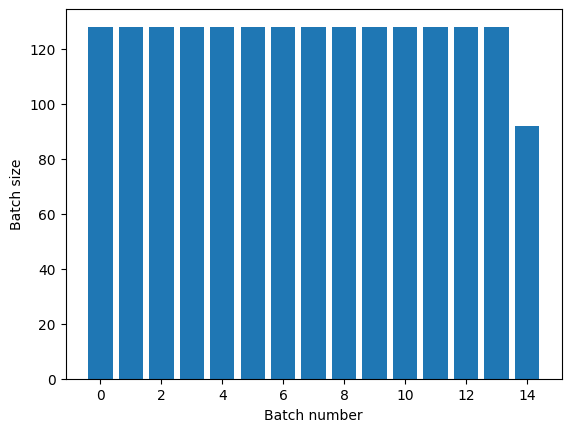

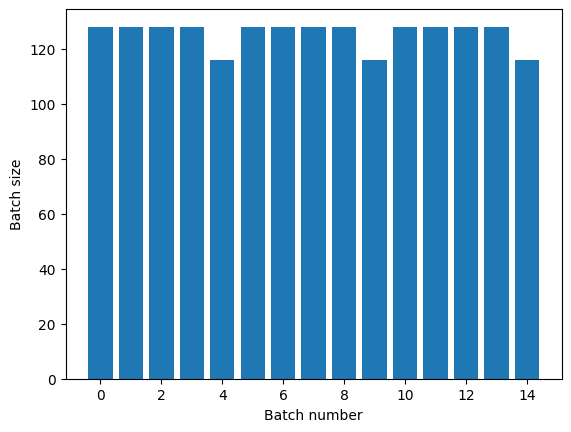

In [23]:
# Dataset.repeat() will keep concatenating repeats of data indefinitely
# There is a count parameter that specifies how many times to repeat the data

# There is no specified divide for "this epoch starts here"
# That is specified by batching; can be done immediately after repeat
# Recall: one batch is used per epoch - can do the math for how you want to split things
titanic_batches = titanic_lines.repeat(3).batch(128)
plot_batch_sizes(titanic_batches)

# If you don't want to do the mathc, batch before repeating
titanic_batches = titanic_lines.batch(128).repeat(3)
plot_batch_sizes(titanic_batches)

In [24]:
# If you need stats on each epoch after it finishes, restart the dataset iteration on each epoch
# Meaning you run it through once per epoch
# Here is an example of what you would do
epochs = 3
dataset = titanic_lines.batch(128)

for epoch in range(epochs):
  for batch in dataset:
    print(batch.shape) # Replace this with epoch computation
  print("End of epoch: ", epoch) # Replace this with end of epoch computation

(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  0
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  1
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  2


## Shuffling input data

This is important to reduce bias that may be present in how your data was collected.

In [33]:
lines = tf.data.TextLineDataset(titanic_file)
counter = tf.data.experimental.Counter()

# The shuffle function primarily needs the buffer_size
# The way it works is it first fills in the buffer with the specified number of elements (taken from the beginning of the dataset)
# Then it randomly samples from that buffer, filling it in with the next data
# Bigger buffers are better, but take up a lot of memory
# To shuffle everything, just specify the buffer size to be the dataset.cardinality() (cardinality = size)

# Other parameters include:
# seed (for deterministic randomness)
# reshuffle_each_iteration - when repeating data (using Dataset.repeat()), the data is reshuffled
# A name
dataset = tf.data.Dataset.zip((counter, lines))
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.batch(20)

# Here the dataset will have no element with an index over 120
# This is because the first 100 elements filled into the buffer, then 20 are chosen
# In that process of choosing each element, the next is subbed in
# Can rerun the code to see that this is true
print(dataset)
n, line_batch = next(iter(dataset))
print(n.numpy())

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>
[ 77  96  27  85  93  61  11  65  69 105  35  46  53  51  23  20  90  75
  28  26]


Here are the item ID's near the epoch boundary:

[245 399 619 402 519 599 410 602 613 559]
[590 606 546 615 607 498 622 589 544 415]
[508 574 610 617 294 612 526 601]
[91 80 56 25 18 57 40 55 70 88]
[ 30 109 103  82  77 101 104  60 100  68]


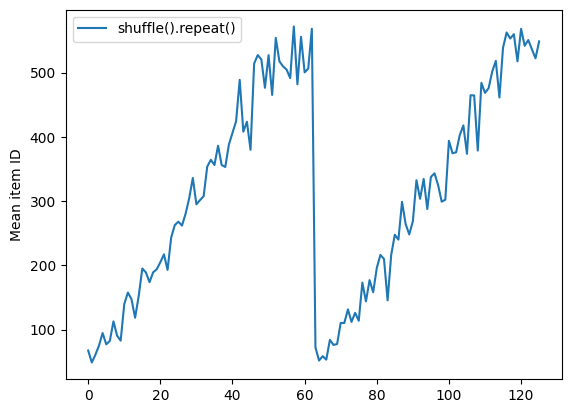

In [37]:
# Order of shuffling matters relative to repeating data
# Shuffling doesn't 'end' the epoch until the buffer is empty
# Placing it before a repeat will show all the elements in one epoch before moving on
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.shuffle(buffer_size=100).batch(10).repeat(2)

# ID's near epoch boundary
print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(60).take(5):
  print(n.numpy())

# Here, you can visualize the repeated data by looking at the mean of the values grabbed
shuffle_repeat = [n.numpy().mean() for n, line_batch in shuffled]
plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.ylabel("Mean item ID")
plt.legend()
plt.show()

Here are the item ID's near the epoch boundary:

[399 601 582 592 616 548 553 586 512 585]
[ 31 626  18 482 618 624   5 534  13 595]
[338  17  27  29 609 579 393 613   6   1]
[615 187   8 617  25 390  48 542   4 487]
[ 16 588  26  35   9 327  40 376  12 504]
[ 28  69  37 467  22 598 573  44  73 511]
[ 54  11  21  70 564  71 535  20  53  15]
[566  46  55 531  41  30 332  67  78 627]
[  3  97 222  60 101  43 544  99   7  68]
[ 14 563  57 620  62  82  24  81  85 611]
[116 607 316  64  84 590 603  49 622  90]
[570 401 102  72 132  83 606 105 623  74]
[  2  96 572  59 599 124 114 519 529  98]
[ 39  76 106 129 128 138 119 580  42 118]
[122 371 112 600  36 605 596 583 137  32]


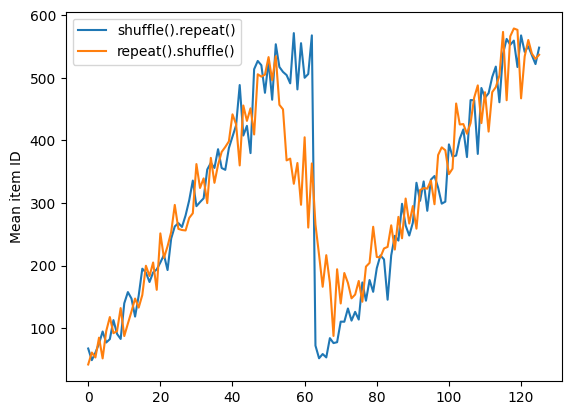

In [38]:
# Putting it before the repeat mixes the boundaries
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.repeat(2).shuffle(buffer_size=100).batch(10)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(55).take(15):
  print(n.numpy())

# Here, you can see that the boundary is less clear for when the data repeats
repeat_shuffle = [n.numpy().mean() for n, line_batch in shuffled]

plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.plot(repeat_shuffle, label="repeat().shuffle()")
plt.ylabel("Mean item ID")
plt.legend()
plt.show()

# Iterator Checkpointing
Goal: To have checkpoints remembering where we left off in a dataset (especially for large ones)

May take a large amount of memory because of the large buffers from prefetching and shuffling.

In [21]:
# Setting up a random dataset
range_ds = tf.data.Dataset.range(20)

# Will not work on iterator that relies on external state
# The iterator and checkpoints
iterator = iter(range_ds)
chkpt = tf.train.Checkpoint(step=tf.Variable(0), iterator=iterator)
manager = tf.train.CheckpointManager(chkpt, '/tmp/my_chkpt', max_to_keep=3)

print([next(iterator).numpy() for _ in range(5)])

save_path = manager.save()


print([next(iterator).numpy() for _ in range(5)])

chkpt.restore(manager.latest_checkpoint)

print([next(iterator).numpy() for _ in range(5)])

[0, 1, 2, 3, 4]
[5, 6, 7, 8, 9]
[5, 6, 7, 8, 9]
